## 准确率（Score）和交叉检验准确率（cross-validated scores）
每个模型（估计器）都会暴露一个score方法，来判断其对新数据的拟合程度。

其值越大越好

In [1]:
from sklearn import datasets, svm
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target
svc = svm.SVC(C=1, kernel='linear')
svc.fit(X_digits[:-100], y_digits[:-100]).score(X_digits[-100:], y_digits[-100:])

0.97999999999999998

为了得到一个更好的预测精度。我们可以将数据划分成训练集和测试集。

In [2]:
import numpy as np
X_folds = np.array_split(X_digits, 3)
y_folds = np.array_split(y_digits, 3)
scores = list()
for k in range(3):
    # We use 'list' to copy, in order to 'pop' later on
    X_train = list(X_folds)
    X_test  = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test  = y_train.pop(k)
    y_train = np.concatenate(y_train)
    scores.append(svc.fit(X_train, y_train).score(X_test, y_test))
print(scores)

[0.93489148580968284, 0.95659432387312182, 0.93989983305509184]


上面一段代码选取了2/3的数据作为训练，1/3的数据作为测试。

称为[KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)交叉验证。

## 交叉检验生成器
上面的方法是不是有点麻烦？

scikit-learn中已经有一些类可以用来生成交叉检验的类，它们暴露了一个split方法，可以分割训练集和测试集

In [3]:
from sklearn.model_selection import KFold, cross_val_score
X = ["a", "a", "b", "c", "c", "c"]
k_fold = KFold(n_splits=3)
for train_indices, test_indices in k_fold.split(X):
     print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [2 3 4 5] | test: [0 1]
Train: [0 1 4 5] | test: [2 3]
Train: [0 1 2 3] | test: [4 5]


可以简单的进行交叉验证测试

In [4]:
kfold = KFold(n_splits=3)
[svc.fit(X_digits[train], y_digits[train]).score(X_digits[test], y_digits[test])
         for train, test in k_fold.split(X_digits)]

[0.93489148580968284, 0.95659432387312182, 0.93989983305509184]

**还可以更简单！**

交叉检验的准确率可以使用`cross_val_score`来生成。

下面举一个小例子，具体的可以查看[文档](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)。

In [5]:
cross_val_score(svc, X_digits, y_digits, cv=k_fold, n_jobs=-1)

array([ 0.93489149,  0.95659432,  0.93989983])

n_jobs=-1意思是计算会分配到所有的CPU中

scoring参数可以提供特定的准确度算法

In [6]:
cross_val_score(svc, X_digits, y_digits, cv=k_fold,
                scoring='precision_macro')

array([ 0.93969761,  0.95911415,  0.94041254])

### 练习
对于数字识别数据集，使用线性（逻辑回归）的SVC评估器。

画出正则参数C从1到10变化的准确率。

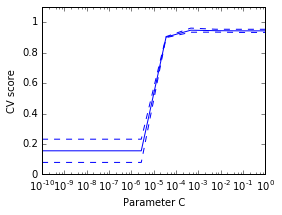

In [7]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import datasets, svm

digits = datasets.load_digits()
X = digits.data
y = digits.target

svc = svm.SVC(kernel='linear')
C_s = np.logspace(-10, 0, 10)

scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()

## 格搜索（Grid-search）和交叉检验估计器（cross-validated estimators）
### 格搜索
格搜索可以在格参数之间进行搜索，找到使交叉检验准确率最小的参数。

In [9]:
from sklearn.model_selection import GridSearchCV, cross_val_score
Cs = np.logspace(-6, -1, 10)
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs),n_jobs=-1)
clf.fit(X_digits[:1000], y_digits[:1000])  

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-06,   3.59381e-06,   1.29155e-05,   4.64159e-05,
         1.66810e-04,   5.99484e-04,   2.15443e-03,   7.74264e-03,
         2.78256e-02,   1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [10]:
clf.best_score_ 

0.92500000000000004

In [11]:
clf.best_estimator_.C 

0.0077426368268112772

进行预测

In [12]:
# Prediction performance on test set is not as good as on train set
clf.score(X_digits[1000:], y_digits[1000:])   

0.94353826850690092

默认情况下，格搜索使用3-fold（也就是训练集和测试集比例2:1）交叉检验。然而，如果检测到估计器是分类而不是回归，则使用分层3-flod。

**还有更高级的用法**（在kaggle中一定要用上）

**和前面的那个cross_val_score方法嵌套！**

In [13]:
cross_val_score(clf, X_digits, y_digits)

array([ 0.93853821,  0.96327212,  0.94463087])

在这种使用方法下，两个loop是并行的。GridSearchCV估计参数，cross_val_score预测参数对估计器的影响。

### 交叉检验估计
对于每个具体的模型，scikit-learn暴露了Cross-validation方法。能够自动的找到合适的参数。

通常来讲，带有交叉检验功能的估计器在原有的估计器后面加上'CV'就行。

In [14]:
from sklearn import linear_model, datasets
lasso = linear_model.LassoCV()
diabetes = datasets.load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target
lasso.fit(X_diabetes, y_diabetes)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

对于糖尿病的例子，找到合适的参数

In [15]:
# The estimator chose automatically its lambda:
lasso.alpha_ 

0.012291895087486161

### 练习
对于糖尿病的例子，找到最佳的正则参数

Automatically created module for IPython interactive environment


(0.0001, 0.31622776601683794)

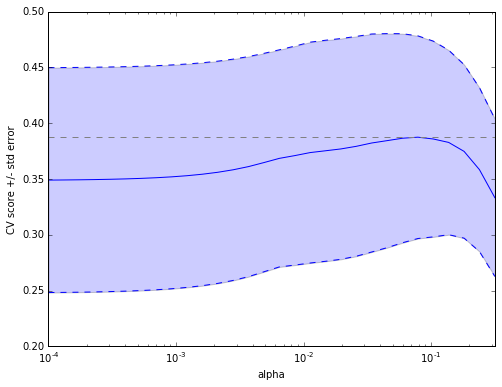

In [20]:
from __future__ import print_function
print(__doc__)

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

diabetes = datasets.load_diabetes()
X = diabetes.data[:150]
y = diabetes.target[:150]

lasso = Lasso(random_state=0)
alphas = np.logspace(-4, -0.5, 30)

scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, X, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

**BQ：我们能相信选出的alpha值吗？**

In [21]:
# To answer this question we use the LassoCV object that sets its alpha
# parameter automatically from the data by internal cross-validation (i.e. it
# performs cross-validation on the training data it receives).
# We use external cross-validation to see how much the automatically obtained
# alphas differ across different cross-validation folds.
lasso_cv = LassoCV(alphas=alphas, random_state=0)
k_fold = KFold(3)

print("Answer to the bonus question:",
      "how much can you trust the selection of alpha?")
print()
print("Alpha parameters maximising the generalization score on different")
print("subsets of the data:")
for k, (train, test) in enumerate(k_fold.split(X, y)):
    lasso_cv.fit(X[train], y[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(k, lasso_cv.alpha_, lasso_cv.score(X[test], y[test])))
print()
print("Answer: Not very much since we obtained different alphas for different")
print("subsets of the data and moreover, the scores for these alphas differ")
print("quite substantially.")

plt.show()

Answer to the bonus question: how much can you trust the selection of alpha?

Alpha parameters maximising the generalization score on different
subsets of the data:
[fold 0] alpha: 0.10405, score: 0.53573
[fold 1] alpha: 0.05968, score: 0.16278
[fold 2] alpha: 0.10405, score: 0.44437

Answer: Not very much since we obtained different alphas for different
subsets of the data and moreover, the scores for these alphas differ
quite substantially.
